In [7]:
#kaggle에서 자료 다운로드

import kagglehub

path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Path to dataset files: /kaggle/input/new-plant-diseases-dataset


Creating the training dataset...
Found 70295 files belonging to 38 classes.
Creating the validation dataset...
Found 17572 files belonging to 38 classes.

Found the following 38 classes: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


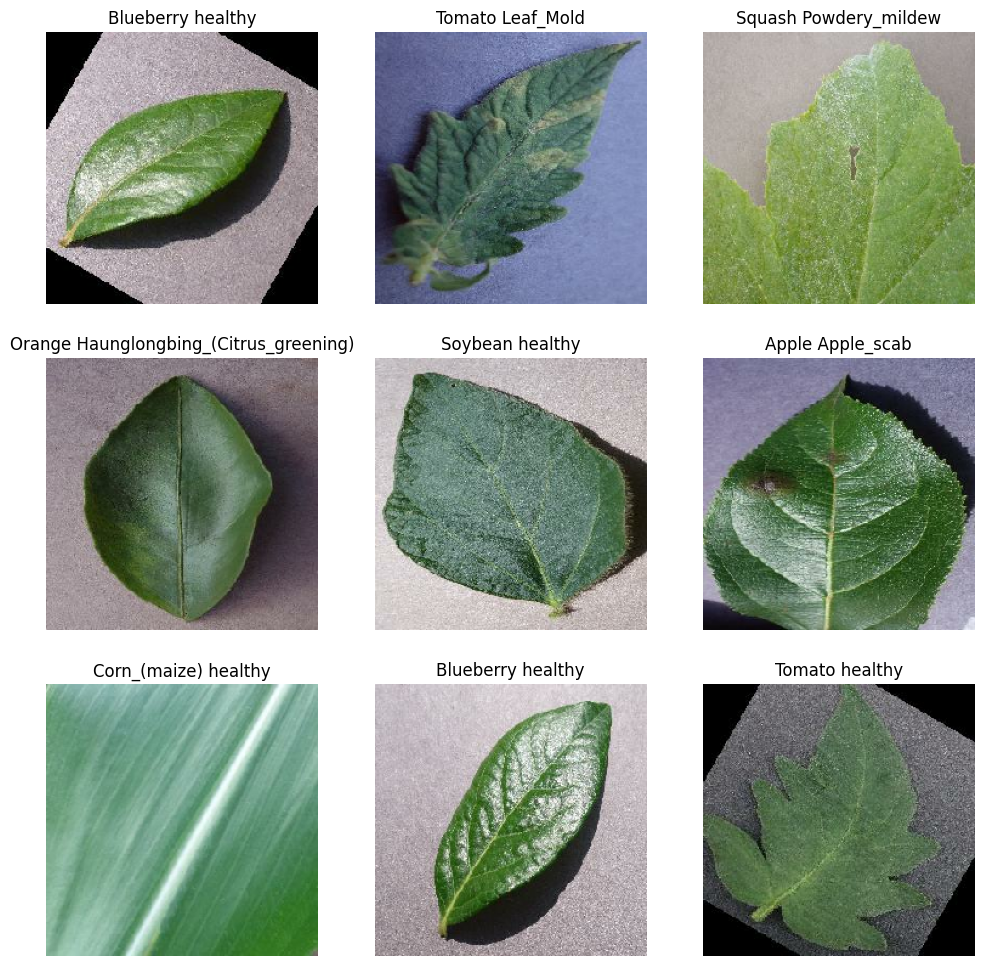

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# --- 1. 경로 설정 ---
# data_dir라는 변수에 경로를 설정합니다.
data_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'

# 파라메타들의 크기 설정
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

# --- 2. 데이터셋 만들기 ---
print("Creating the training dataset...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Creating the validation dataset...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'valid'),
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_dataset.class_names
print(f"\nFound the following {len(class_names)} classes: \n{class_names[:5]}")



# 데이터셋 파이프라인 설정 부분 (Notebook 앞부분에 위치)
AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)  <-- .cache()를 제거

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# --- 4. Batch of Data 시각화 ---
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # 이미지 픽셀 값을 uint8로 변환하여 표시 (0-255 범위 가정)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i])
        plt.title(class_names[label_index].replace("___", " "))
        plt.axis("off")
plt.show()


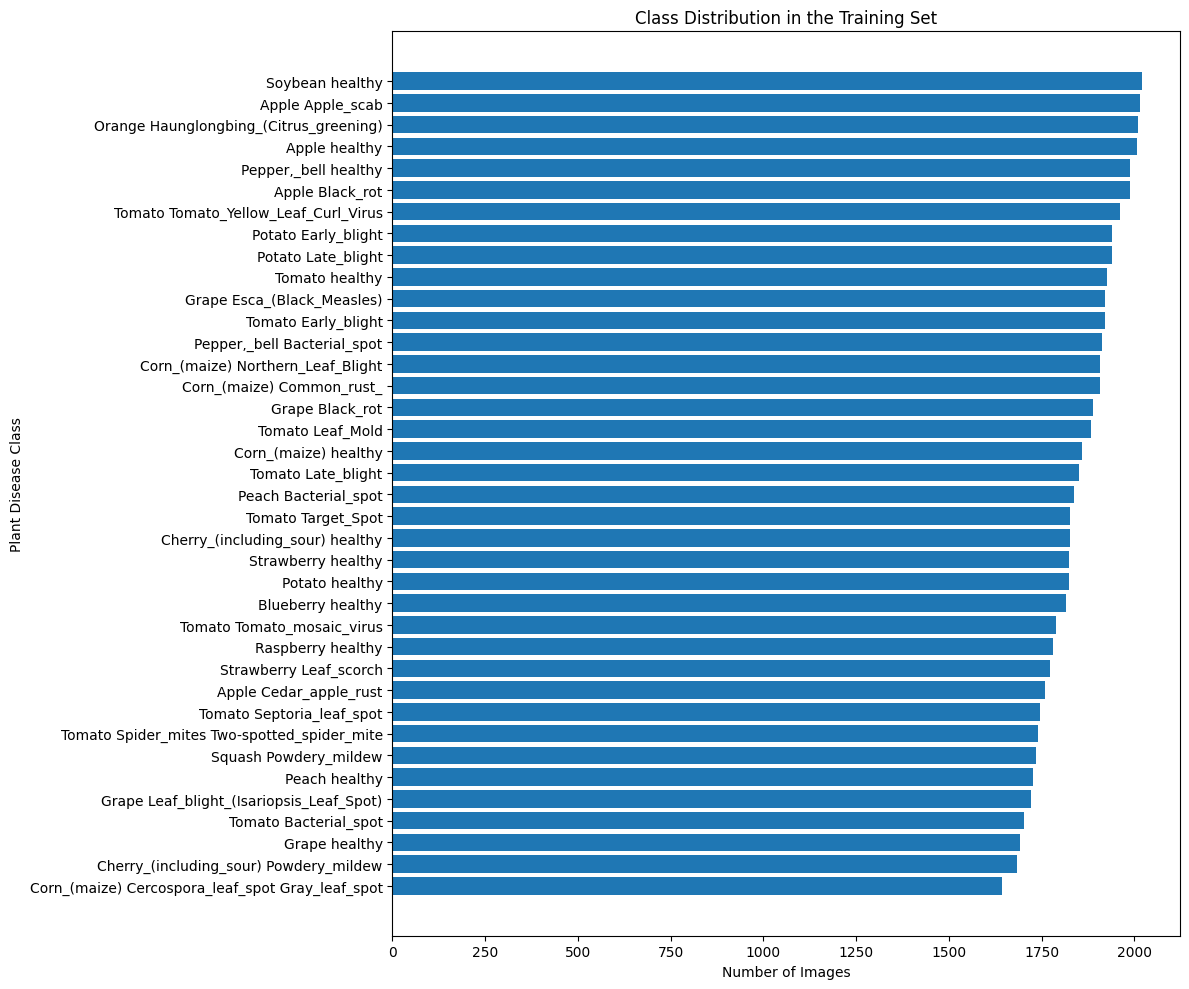

In [3]:
# Path to training directory
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'

class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name.replace("___", " ")] = len(os.listdir(class_path))

sorted_counts = sorted(class_counts.items(), key=lambda item: item[1])
sorted_class_names = [item[0] for item in sorted_counts]
sorted_image_counts = [item[1] for item in sorted_counts]

# Plot the distribution
plt.figure(figsize=(12, 10))
plt.barh(sorted_class_names, sorted_image_counts)
plt.xlabel("Number of Images")
plt.ylabel("Plant Disease Class")
plt.title("Class Distribution in the Training Set")
plt.tight_layout()
plt.show()

In [8]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 필수 변수 재정의 ---
IMG_HEIGHT = 224
IMG_WIDTH = 224

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
INITIAL_EPOCHS = 5
FINE_TUNE_EPOCHS = 20
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- Data Augmentation Pipeline 구축 ---
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ],
    name="data_augmentation",
)

# --- Transfer Learning 모델 제작 ---
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# --- 초기 훈련 모델 컴파일 ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=validation_dataset)

base_model.trainable = True

# OPTIONAL FIX: 파인튜닝을 더 나중 레이어에서 시작하여(예: 100 -> 120),
# 훈련 가능한 파라미터 수를 줄여 메모리 부담을 완화
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- 5. 파인 튜닝 재 컴파일 ---
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.00001)

history_fine = model.fit(train_dataset,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=INITIAL_EPOCHS,
                         validation_data=validation_dataset,
                         callbacks=[early_stopping, reduce_lr])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 189s 83ms/step - accuracy: 0.3169 - loss: 2.5176 - val_accuracy: 0.3444 - val_loss: 2.3688
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 207s 86ms/step - accuracy: 0.5100 - loss: 1.6533 - val_accuracy: 0.3740 - val_loss: 2.2857
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - accuracy: 0.5327 - loss: 1.5759 - val_accuracy: 0.3785 - val_loss: 2.2892
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 207s 85ms/step - accuracy: 0.5444 - loss: 1.5437 - val_accuracy: 0.4041 - val_loss: 2.1823
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - accuracy: 0.5436 - loss: 1.5374 - val_accuracy: 0.3803 - val_loss: 2.3275


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 6/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 278s 120ms/step - accuracy: 0.4982 - loss: 2.2178 - val_accuracy: 0.5227 - val_loss: 2.4764 - learning_rate: 1.0000e-04
Epoch 7/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 318s 118ms/step - accuracy: 0.7863 - loss: 0.6696 - val_accuracy: 0.6414 - val_loss: 1.3817 - learning_rate: 1.0000e-04
Epoch 8/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 262s 118ms/step - accuracy: 0.8471 - loss: 0.4765 - val_accuracy: 0.6879 - val_loss: 1.2016 - learning_rate: 1.0000e-04
Epoch 9/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 260s 119ms/step - accuracy: 0.8778 - loss: 0.3727 - val_accuracy: 0.7656 - val_loss: 0.7815 - learning_rate: 1.0000e-04
Epoch 10/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 263s 119ms/step - accuracy: 0.8990 - loss: 0.3087 - val_accuracy: 0.6823 - val_loss: 1.1856 - learning_rate: 1.0000e-04
Epoch 11/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 260s 118ms/step - accuracy: 0.9114 - loss: 0.2728 - val_accuracy: 0.7125 - val_loss: 1.0191 - learning_rate: 1.0000e-04
Epoch 12/25
2197/2197 ━━━━

In [1]:
# 모델 평가 (evaluation) 코드

print("\n--- 모델 최종 성능 평가 시작 ---")

# model.evaluate() 함수를 사용하여 모델의 최종 성능을 측정합니다.
# 이 함수는 [손실(loss), 정확도(accuracy)] 형태의 리스트를 반환합니다.
loss, accuracy = model.evaluate(validation_dataset)

# 결과를 출력합니다.
print("====================================")
print(f"최종 검증 손실 (Validation Loss): {loss:.4f}")
print(f"최종 검증 정확도 (Validation Accuracy): {accuracy:.4f} ({accuracy * 100:.2f}%)")
print("====================================")

# 참고: model.evaluate()는 .fit()의 마지막 에포크 결과와 비슷할 수 있지만,
# EarlyStopping 등으로 인해 복원된 '최적의 가중치'에 대한 정확한 평가를 제공합니다.


--- 모델 최종 성능 평가 시작 ---


NameError: name 'model' is not defined

In [ ]:
# 8단계 부터 시작
